In [2]:
import dataloader
import sys
import time
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import gc

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, RepeatVector
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, TimeDistributed

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

%load_ext autoreload
%autoreload 2

path = "../032721Comparison/Data/IBIO2021.csv"
date = datetime.datetime(2021,3,12)
count = 1200
# We will use the previous 60 days as features
history_size = 60

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Compute MAE
def mae(y_hat, y):
    # mean absolute error
    return np.abs(y_hat - y).mean()

def rmse(y_hat, y):
    # root mean squared error
    return np.sqrt(np.mean(np.power((y-y_hat),2)))

In [4]:
df = dataloader.load_data_up_to_date(path, date, count)

(1258, 7)
(1257, 7)
(1257, 7)
(1200, 7)


In [5]:
ibio_closing_all = df['Close'].to_numpy()
# reshape to 1200 x 1 matrix
ibio_closing_all = np.reshape(ibio_closing_all, (ibio_closing_all.shape[0], -1))
ibio_closing_all.shape

(1200, 1)

In [6]:
#converting prices to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ibio_closing_all)
train = scaled_data[:1000,:]
test = scaled_data[1000:, :]

In [7]:
train_x, train_y = [], []
test_x, test_y = [], []
for i in range(history_size,len(train)):
    train_x.append(scaled_data[i-history_size:i,0])
    train_y.append(scaled_data[i,0])
train_x, train_y = np.array(train_x), np.array(train_y)

train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1], 1))
print(train_x.shape)

for i in range(len(train),len(scaled_data)):
    test_x.append(scaled_data[i-history_size:i,0])
    test_y.append(scaled_data[i,0])
test_x, test_y = np.array(test_x), np.array(test_y)

test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1], 1))
print(test_x.shape)

(940, 60, 1)
(200, 60, 1)


In [8]:
# How many features do we want to pass as hidden unit
UNITS = range(30, 60, 5)
FILTERS = [2, 4, 8, 16, 32]
KERNELS = [2, 4, 8, 16]
K = 5
model = None
gc.collect()

best_config = None
# Best Validation Error
best_err = sys.maxsize

for filter_size in FILTERS:
    for kernel_size in KERNELS:
        for unit_count in UNITS:
            kf = KFold(n_splits=K, random_state=None, shuffle=False)
            y_err = []

            # Cross Validaiton
            for train_index, val_index in kf.split(train_x):
                X_train, X_val = train_x[train_index], train_x[val_index]
                y_train, y_val = train_y[train_index], train_y[val_index]

                model = Sequential()
                model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', input_shape=(train_x.shape[1],train_x.shape[2])))
                model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
                model.add(MaxPooling1D(pool_size=2))
                model.add(Flatten())
                model.add(RepeatVector(1))
                model.add(LSTM(units=unit_count, return_sequences=True))
                model.add(Flatten())
                model.add(Dense(unit_count))
                model.add(Dense(1))
                model.compile(loss='mean_squared_error', optimizer='adam')
                model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
                y_hat = model.predict(X_val).transpose()[0]
                del model
                gc.collect()

                y_err.append(rmse(y_hat, y_val))

            print(filter_size, kernel_size, unit_count, "mean val RMSE:", np.mean(y_err))

            if np.mean(y_err) < best_err:
                best_err = np.mean(y_err)
                best_config = (filter_size, kernel_size, unit_count)

print(best_config, best_err)

2 2 30 mean val RMSE: 0.06230329697049678
2 2 35 mean val RMSE: 0.06371370176959017
2 2 40 mean val RMSE: 0.07728130838528355
2 2 45 mean val RMSE: 0.05693461055852968
2 2 50 mean val RMSE: 0.14391603339966347
2 2 55 mean val RMSE: 0.03183615449169287
2 4 30 mean val RMSE: 0.118594011139039
2 4 35 mean val RMSE: 0.043735591933083504
2 4 40 mean val RMSE: 0.07830102671607046
2 4 45 mean val RMSE: 0.12295031269880652
2 4 50 mean val RMSE: 0.08197112500651511
2 4 55 mean val RMSE: 0.043279991527176494
2 8 30 mean val RMSE: 0.07949190874654072
2 8 35 mean val RMSE: 0.12519104557712685
2 8 40 mean val RMSE: 0.15606527390498856
2 8 45 mean val RMSE: 0.0583117122676637
2 8 50 mean val RMSE: 0.046127367649184924
2 8 55 mean val RMSE: 0.09280594679130223
2 16 30 mean val RMSE: 0.11011353093808711
2 16 35 mean val RMSE: 0.14277808836604422
2 16 40 mean val RMSE: 0.04433586621400869
2 16 45 mean val RMSE: 0.10017903135495025
2 16 50 mean val RMSE: 0.11803543702044703
2 16 55 mean val RMSE: 0.0714

In [9]:
model = None
gc.collect()

model = Sequential()
model.add(Conv1D(filters=best_config[0], kernel_size=best_config[1], activation='relu', input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(Conv1D(filters=best_config[0], kernel_size=best_config[1], activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(1))
model.add(LSTM(units=best_config[2], return_sequences=True))
model.add(Flatten())
model.add(Dense(best_config[2]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=1000, batch_size=32, verbose=1)
print(model.summary())
y_hat = model.predict(test_x).transpose()[0]

del model
gc.collect()

Epoch 1/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0195
Epoch 2/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 3/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 4/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 5/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 6/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 7/1000
30/30 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 8/1000
30/30 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 9/1000
30/30 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 10/1000
30/30 [==============================] - 0s 7ms/step - loss: 9.2533e-04
Epoch 11/1000
30/30 [==============================] - 0s 7ms/step - loss: 8.9728e-04
Epoch 12/1000
30/30 [==============================] - 0s 7ms/step - loss: 8.0234e-04
Epoch 13/1000

30/30 [==============================] - 0s 7ms/step - loss: 4.7789e-04
Epoch 97/1000
30/30 [==============================] - 0s 7ms/step - loss: 3.8956e-04
Epoch 98/1000
30/30 [==============================] - 0s 7ms/step - loss: 5.5247e-04
Epoch 99/1000
30/30 [==============================] - 0s 7ms/step - loss: 3.9730e-04
Epoch 100/1000
30/30 [==============================] - 0s 5ms/step - loss: 3.9275e-04
Epoch 101/1000
30/30 [==============================] - 0s 4ms/step - loss: 3.8825e-04
Epoch 102/1000
30/30 [==============================] - 0s 4ms/step - loss: 4.0414e-04
Epoch 103/1000
30/30 [==============================] - 0s 6ms/step - loss: 3.6133e-04
Epoch 104/1000
30/30 [==============================] - 0s 6ms/step - loss: 3.3723e-04
Epoch 105/1000
30/30 [==============================] - 0s 6ms/step - loss: 3.4949e-04
Epoch 106/1000
30/30 [==============================] - 0s 6ms/step - loss: 3.5601e-04
Epoch 107/1000
30/30 [==============================] - 0s 6m

30/30 [==============================] - 0s 5ms/step - loss: 3.0865e-04
Epoch 191/1000
30/30 [==============================] - 0s 5ms/step - loss: 4.0696e-04
Epoch 192/1000
30/30 [==============================] - 0s 5ms/step - loss: 3.6490e-04
Epoch 193/1000
30/30 [==============================] - 0s 5ms/step - loss: 4.0308e-04
Epoch 194/1000
30/30 [==============================] - 0s 6ms/step - loss: 3.8721e-04
Epoch 195/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.9323e-04
Epoch 196/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.6577e-04
Epoch 197/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.4211e-04
Epoch 198/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.8651e-04
Epoch 199/1000
30/30 [==============================] - 0s 6ms/step - loss: 3.4223e-04
Epoch 200/1000
30/30 [==============================] - 0s 6ms/step - loss: 3.1977e-04
Epoch 201/1000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 7ms/step - loss: 2.3927e-04
Epoch 285/1000
30/30 [==============================] - 0s 7ms/step - loss: 2.1350e-04
Epoch 286/1000
30/30 [==============================] - 0s 7ms/step - loss: 2.3541e-04
Epoch 287/1000
30/30 [==============================] - 0s 7ms/step - loss: 2.0063e-04
Epoch 288/1000
30/30 [==============================] - 0s 7ms/step - loss: 2.4312e-04
Epoch 289/1000
30/30 [==============================] - 0s 7ms/step - loss: 2.4464e-04
Epoch 290/1000
30/30 [==============================] - 0s 7ms/step - loss: 1.9876e-04
Epoch 291/1000
30/30 [==============================] - 0s 7ms/step - loss: 2.0914e-04
Epoch 292/1000
30/30 [==============================] - 0s 7ms/step - loss: 1.9879e-04
Epoch 293/1000
30/30 [==============================] - 0s 7ms/step - loss: 2.0784e-04
Epoch 294/1000
30/30 [==============================] - 0s 7ms/step - loss: 2.7617e-04
Epoch 295/1000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 7ms/step - loss: 1.6198e-04
Epoch 379/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.8196e-04
Epoch 380/1000
30/30 [==============================] - 0s 4ms/step - loss: 2.3507e-04
Epoch 381/1000
30/30 [==============================] - 0s 4ms/step - loss: 1.7899e-04
Epoch 382/1000
30/30 [==============================] - 0s 4ms/step - loss: 1.8348e-04
Epoch 383/1000
30/30 [==============================] - 0s 4ms/step - loss: 3.1639e-04
Epoch 384/1000
30/30 [==============================] - 0s 4ms/step - loss: 2.0595e-04
Epoch 385/1000
30/30 [==============================] - 0s 4ms/step - loss: 1.5685e-04
Epoch 386/1000
30/30 [==============================] - 0s 4ms/step - loss: 1.7334e-04
Epoch 387/1000
30/30 [==============================] - 0s 5ms/step - loss: 1.3713e-04
Epoch 388/1000
30/30 [==============================] - 0s 5ms/step - loss: 1.6996e-04
Epoch 389/1000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 1.1126e-04
Epoch 473/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.3507e-04
Epoch 474/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.3657e-04
Epoch 475/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.1616e-04
Epoch 476/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.2939e-04
Epoch 477/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.1291e-04
Epoch 478/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.2519e-04
Epoch 479/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.0633e-04
Epoch 480/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.3834e-04
Epoch 481/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.3630e-04
Epoch 482/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.8786e-04
Epoch 483/1000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 7.5072e-05
Epoch 567/1000
30/30 [==============================] - 0s 6ms/step - loss: 8.6452e-05
Epoch 568/1000
30/30 [==============================] - 0s 6ms/step - loss: 7.6243e-05
Epoch 569/1000
30/30 [==============================] - 0s 6ms/step - loss: 7.6051e-05
Epoch 570/1000
30/30 [==============================] - 0s 6ms/step - loss: 7.5101e-05
Epoch 571/1000
30/30 [==============================] - 0s 6ms/step - loss: 6.7764e-05
Epoch 572/1000
30/30 [==============================] - 0s 6ms/step - loss: 7.7935e-05
Epoch 573/1000
30/30 [==============================] - 0s 6ms/step - loss: 8.0681e-05
Epoch 574/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.5822e-04
Epoch 575/1000
30/30 [==============================] - 0s 6ms/step - loss: 1.0757e-04
Epoch 576/1000
30/30 [==============================] - 0s 6ms/step - loss: 8.9843e-05
Epoch 577/1000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 6.9555e-05
Epoch 661/1000
30/30 [==============================] - 0s 6ms/step - loss: 5.5629e-05
Epoch 662/1000
30/30 [==============================] - 0s 6ms/step - loss: 5.9911e-05
Epoch 663/1000
30/30 [==============================] - 0s 6ms/step - loss: 4.6237e-05
Epoch 664/1000
30/30 [==============================] - 0s 6ms/step - loss: 4.5795e-05
Epoch 665/1000
30/30 [==============================] - 0s 6ms/step - loss: 4.8191e-05
Epoch 666/1000
30/30 [==============================] - 0s 6ms/step - loss: 4.9146e-05
Epoch 667/1000
30/30 [==============================] - 0s 6ms/step - loss: 7.6872e-05
Epoch 668/1000
30/30 [==============================] - 0s 6ms/step - loss: 5.3029e-05
Epoch 669/1000
30/30 [==============================] - 0s 6ms/step - loss: 4.5295e-05
Epoch 670/1000
30/30 [==============================] - 0s 6ms/step - loss: 3.9295e-05
Epoch 671/1000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 7ms/step - loss: 4.1350e-05
Epoch 755/1000
30/30 [==============================] - 0s 7ms/step - loss: 3.4798e-05
Epoch 756/1000
30/30 [==============================] - 0s 7ms/step - loss: 3.8592e-05
Epoch 757/1000
30/30 [==============================] - 0s 7ms/step - loss: 3.0958e-05
Epoch 758/1000
30/30 [==============================] - 0s 7ms/step - loss: 5.1474e-05
Epoch 759/1000
30/30 [==============================] - 0s 7ms/step - loss: 5.2521e-05
Epoch 760/1000
30/30 [==============================] - 0s 7ms/step - loss: 3.7553e-05
Epoch 761/1000
30/30 [==============================] - 0s 7ms/step - loss: 3.2440e-05
Epoch 762/1000
30/30 [==============================] - 0s 7ms/step - loss: 4.6313e-05
Epoch 763/1000
30/30 [==============================] - 0s 7ms/step - loss: 3.3700e-05
Epoch 764/1000
30/30 [==============================] - 0s 7ms/step - loss: 3.1099e-05
Epoch 765/1000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 1.9020e-05
Epoch 849/1000
30/30 [==============================] - 0s 6ms/step - loss: 4.8363e-05
Epoch 850/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.7237e-05
Epoch 851/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.4338e-05
Epoch 852/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.4575e-05
Epoch 853/1000
30/30 [==============================] - 0s 6ms/step - loss: 4.8296e-05
Epoch 854/1000
30/30 [==============================] - 0s 6ms/step - loss: 4.4828e-05
Epoch 855/1000
30/30 [==============================] - 0s 6ms/step - loss: 3.2168e-05
Epoch 856/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.5090e-05
Epoch 857/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.7395e-05
Epoch 858/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.3509e-05
Epoch 859/1000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 2.0134e-05
Epoch 943/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.2292e-05
Epoch 944/1000
30/30 [==============================] - 0s 6ms/step - loss: 3.0625e-05
Epoch 945/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.4975e-05
Epoch 946/1000
30/30 [==============================] - 0s 5ms/step - loss: 2.5353e-05
Epoch 947/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.0235e-05
Epoch 948/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.4860e-05
Epoch 949/1000
30/30 [==============================] - 0s 6ms/step - loss: 6.0508e-05
Epoch 950/1000
30/30 [==============================] - 0s 6ms/step - loss: 6.5110e-05
Epoch 951/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.7524e-05
Epoch 952/1000
30/30 [==============================] - 0s 6ms/step - loss: 2.0980e-05
Epoch 953/1000
30/30 [==============================] - 0s

20723

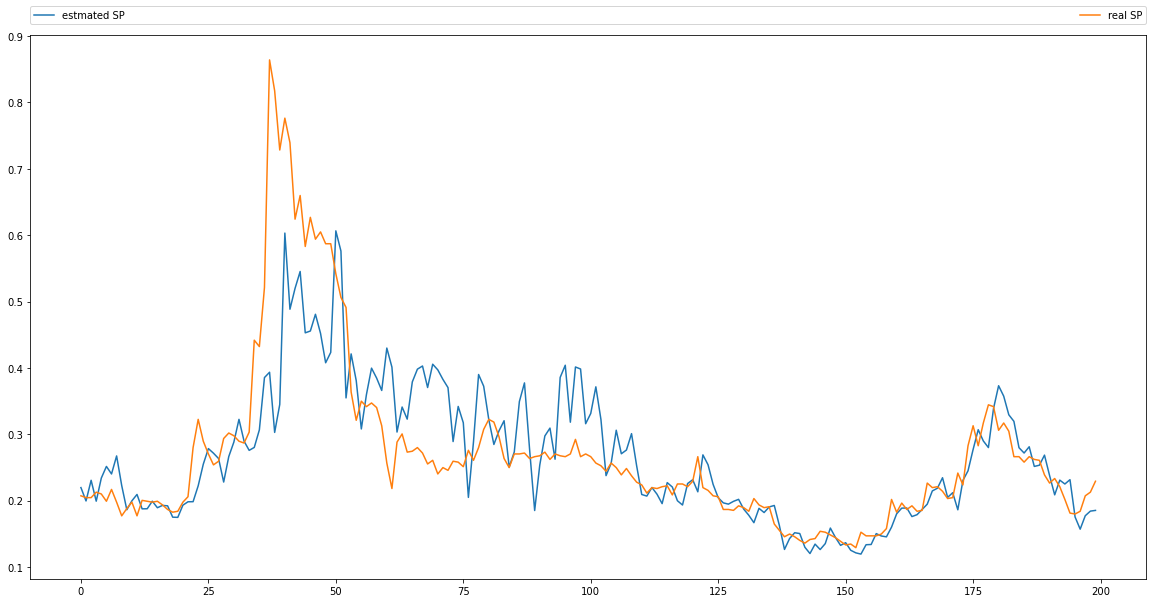

In [10]:
plt.plot(y_hat[:], label="estmated SP")
plt.plot(test_y[:], label="real SP")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [11]:
print("MAE:  ", mae(y_hat, test_y))
print("RMSE: ", rmse(y_hat, test_y))

MAE:   0.04905641346444237
RMSE:  0.08527363496925715
